In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

file_path = '/content/Cleaned_Air_Traffic_Passenger_Statistics.csv'
data = pd.read_csv(file_path)

data['Activity Period'] = pd.to_datetime(data['Activity Period'])
data.set_index('Activity Period', inplace=True)




Before Differencing:
ADF Statistic: 0.23418957792502287
p-value: 0.974115293261253
Critical Values: {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}

After Differencing:
ADF Statistic: -3.2112494468704442
p-value: 0.019342681768357423
Critical Values: {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}


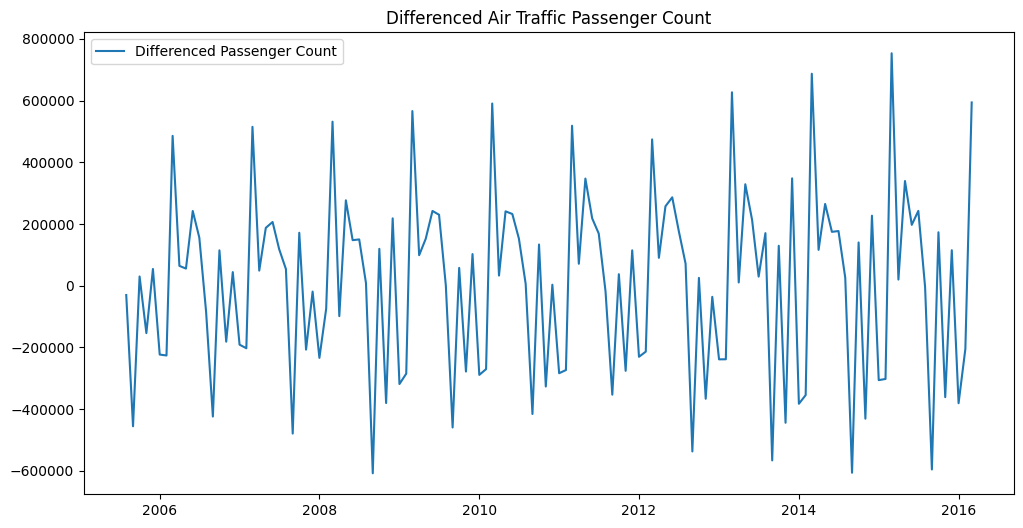

In [ ]:

def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

print("Before Differencing:")
adf_test(data['Passenger Count'])


data_diff = data['Passenger Count'].diff().dropna()

print("\nAfter Differencing:")
adf_test(data_diff)


plt.figure(figsize=(12, 6))
plt.plot(data_diff, label='Differenced Passenger Count')
plt.title('Differenced Air Traffic Passenger Count')
plt.legend()
plt.show()


In [ ]:
# ARIMA Model Forecasting
def arima_forecast(data, forecast_steps=12):
    p, d, q = 1, 1, 1  # You can adjust p, d, q based on ACF/PACF plots

    # Fit ARIMA model
    arima_model = ARIMA(data['Passenger Count'], order=(p, d, q))
    arima_result = arima_model.fit()

    # Forecast
    forecast = arima_result.forecast(steps=forecast_steps)

    # Create a DataFrame for the forecasted values
    forecast_dates = pd.date_range(data.index[-1], periods=forecast_steps + 1, freq='M')[1:]
    arima_forecast_df = pd.DataFrame({'Date': forecast_dates, 'Passenger Count': np.round(forecast, 2)})
    arima_forecast_df.set_index('Date', inplace=True)

    return arima_forecast_df

# Get ARIMA forecast for the next 12 months
arima_forecast_df = arima_forecast(data, forecast_steps=12)

# Display ARIMA forecast
arima_forecast_df


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-54-cb4b3383fcf2>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(data.index[-1], periods=forecast_steps + 1, freq='M')[1:]


,Passenger Count
Date,
2016-04-30,4093985.23
2016-05-31,4099834.47
2016-06-30,4099051.44
2016-07-31,4099156.26
2016-08-31,4099142.23
2016-09-30,4099144.10
2016-10-31,4099143.85
2016-11-30,4099143.89
2016-12-31,4099143.88


In [ ]:
# LSTM Model Forecasting
def lstm_forecast(data, forecast_steps=12):
    # Scale the data for LSTM model
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[['Passenger Count']])

    # Prepare data for LSTM
    time_steps = 12  # Using last 12 months to predict the next
    generator = TimeseriesGenerator(data_scaled, data_scaled, length=time_steps, batch_size=1)

    # Build and train the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(time_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(generator, epochs=20, verbose=0)

    # Prepare initial data for forecasting
    data_slice = data[-time_steps:]
    data_scaled_slice = scaler.transform(data_slice[['Passenger Count']])

    # Generate forecast
    lstm_forecast = []
    current_batch = data_scaled_slice.reshape((1, time_steps, 1))

    for i in range(forecast_steps):
        lstm_pred = model.predict(current_batch)[0]
        lstm_forecast.append(lstm_pred)
        current_batch = np.append(current_batch[:, 1:, :], [[lstm_pred]], axis=1)

    # Inverse scale the forecasted values
    lstm_forecast = scaler.inverse_transform(lstm_forecast)
    lstm_forecast = np.round(lstm_forecast, 2)

    # Create a DataFrame for the forecasted values
    forecast_dates = pd.date_range(data.index[-1], periods=forecast_steps + 1, freq='ME')[1:]
    lstm_forecast_df = pd.DataFrame({'Date': forecast_dates, 'Passenger Count': lstm_forecast.flatten()})
    lstm_forecast_df.set_index('Date', inplace=True)

    return lstm_forecast_df

# Get LSTM forecast for the next 12 months
lstm_forecast_df = lstm_forecast(data, forecast_steps=12)

# Display LSTM forecast
lstm_forecast_df


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<ipython-input-55-37a53480f1b3>:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(data.index[-1], periods=forecast_steps + 1, freq='M')[1:]


,Passenger Count
Date,
2016-04-30,4223166.38
2016-05-31,4504100.37
2016-06-30,4751687.44
2016-07-31,4888523.10
2016-08-31,4846225.02
2016-09-30,4560572.50
2016-10-31,4535487.71
2016-11-30,4276892.15
2016-12-31,4162610.52


In [ ]:
# Calculate MSE for ARIMA
arima_mse = mean_squared_error(data['Passenger Count'][-12:], arima_forecast_df['Passenger Count'])
print(f"ARIMA Mean Squared Error: {arima_mse}")

# Calculate MSE for LSTM
lstm_mse = mean_squared_error(data['Passenger Count'][-12:], lstm_forecast_df['Passenger Count'])
print(f"LSTM Mean Squared Error: {lstm_mse}")


ARIMA Mean Squared Error: 149293014373.70416
LSTM Mean Squared Error: 506196606543.77374


Enter the start date for the forecast (YYYY-MM-DD): 2024-11-23


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Not enough data available before 2024-11-23 00:00:00. Using the earliest available data.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-64-b8ae9be3a19d>:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start_date, periods=forecast_steps + 1, freq='M')[1:]  # Generate forecast dates


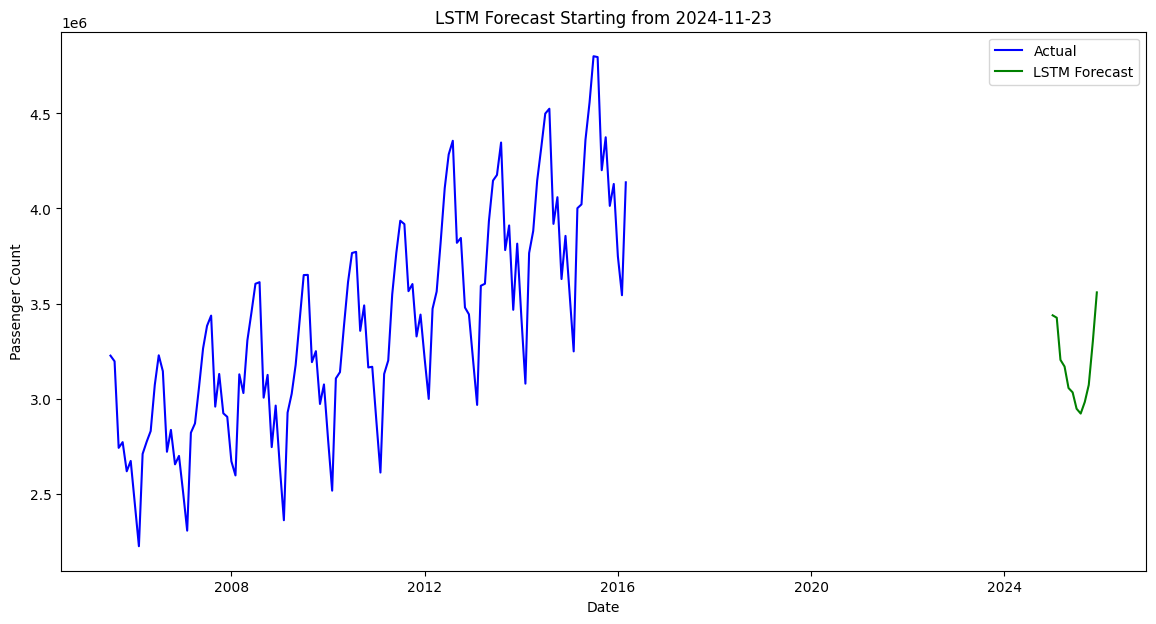

LSTM Forecast:
            Passenger Count
Date                       
2024-12-31        3437915.0
2025-01-31        3425200.0
2025-02-28        3203451.0
2025-03-31        3168422.0
2025-04-30        3055409.0
2025-05-31        3032494.0
2025-06-30        2946269.0
2025-07-31        2921038.0
2025-08-31        2982147.0
2025-09-30        3071682.0
2025-10-31        3302340.0
2025-11-30        3558611.0


In [ ]:


def lstm_forecast(data, forecast_steps, start_date):
    # Convert start_date to datetime
    try:
        start_date = pd.to_datetime(start_date)
    except Exception as e:
        print(f"Error: {e}. Please enter a valid date in the format YYYY-MM-DD.")
        return None

    # Preprocess the data
    # Scale the passenger count values using MinMaxScaler
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[['Passenger Count']])

    # Create a timeseries generator for LSTM training
    time_steps = 12  # Using last 12 months to predict the next month
    generator = TimeseriesGenerator(data_scaled, data_scaled, length=time_steps, batch_size=1)

    # Build and train the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(time_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(generator, epochs=20, verbose=0)

    # Generate forecast starting from the user-specified start date
    # Ensure we have enough historical data for prediction
    data_slice = data[start_date - pd.DateOffset(months=time_steps):start_date]  # Slice data based on the start date
    if data_slice.empty:
        print(f"Not enough data available before {start_date}. Using the earliest available data.")
        data_slice = data[:time_steps]  # Fallback to the earliest data if insufficient historical data

    # Scale the sliced data for prediction
    data_scaled_slice = scaler.transform(data_slice[['Passenger Count']])

    lstm_forecast = []
    current_batch = data_scaled_slice.reshape((1, time_steps, 1))

    # Forecast for the specified number of months
    for i in range(forecast_steps):
        lstm_pred = model.predict(current_batch)[0]  # Generate prediction
        lstm_forecast.append(lstm_pred)
        current_batch = np.append(current_batch[:, 1:, :], [[lstm_pred]], axis=1)

    # Inverse scale the forecast
    lstm_forecast = scaler.inverse_transform(lstm_forecast)  # Transform back to original scale

    # Create a DataFrame with the forecasted values
    forecast_dates = pd.date_range(start_date, periods=forecast_steps + 1, freq='M')[1:]
    forecast_df = pd.DataFrame({'Date': forecast_dates, 'Passenger Count': np.round(lstm_forecast.flatten())})
    forecast_df.set_index('Date', inplace=True)

    return forecast_df

# Example usage:
start_date = input("Enter the start date for the forecast (YYYY-MM-DD): ")  # User input for start date
forecast_steps = 12  # Forecast for the next 12 months

# Get LSTM forecast
lstm_forecast_df = lstm_forecast(data, forecast_steps, start_date)

# If forecast is None, exit early
if lstm_forecast_df is None:
    print("Exiting due to invalid date input.")
else:
    # Plot the actual and predicted values
    plt.figure(figsize=(14, 7))

    # Plot actual data
    plt.plot(data['Passenger Count'], label='Actual', color='blue')

    # Plot LSTM forecast
    plt.plot(lstm_forecast_df.index, lstm_forecast_df['Passenger Count'], label='LSTM Forecast', color='green')

    # Add labels and title
    plt.title(f"LSTM Forecast Starting from {start_date}")
    plt.xlabel("Date")
    plt.ylabel("Passenger Count")
    plt.legend()

    # Show plot
    plt.show()

    # Display forecasted values
    print("LSTM Forecast:")
    print(lstm_forecast_df)
